# Ookla Broadband Performance Data

This notebook downloads and explores Ookla open data for fixed and mobile broadband performance.

**Important**: Run the cells in order, starting with the configuration cell below.

In [1]:
# Load configuration
%run ../../config.py

Project root: /Users/eric/proj/wireless-income
Data directory: /Users/eric/proj/wireless-income/data


In [2]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import os
from urllib.parse import urlparse

# Create S3 client with no signing (for public buckets)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# List all objects in the bucket
bucket_name = 'ookla-open-data'
response = s3.list_objects_v2(Bucket=bucket_name)

# Separate parquet files and shapefiles
parquet_files = []
shapefiles = []

# Get all objects (handle pagination if needed)
while True:
    for obj in response.get('Contents', []):
        key = obj['Key']
        if key.endswith('.parquet'):
            parquet_files.append(f"s3://{bucket_name}/{key}")
        elif key.endswith('.zip'):
            shapefiles.append(f"s3://{bucket_name}/{key}")
    
    # Check if there are more results
    if response.get('IsTruncated'):
        response = s3.list_objects_v2(
            Bucket=bucket_name,
            ContinuationToken=response['NextContinuationToken']
        )
    else:
        break

print(f"Found {len(parquet_files)} parquet files")
print(f"Found {len(shapefiles)} shapefiles")

# Display first few of each
print("\nFirst 5 parquet files:")
for f in parquet_files[:5]:
    print(f"  {f}")

print("\nFirst 5 shapefiles:")
for f in shapefiles[:5]:
    print(f"  {f}")

Found 54 parquet files
Found 54 shapefiles

First 5 parquet files:
  s3://ookla-open-data/parquet/performance/type=fixed/year=2019/quarter=1/2019-01-01_performance_fixed_tiles.parquet
  s3://ookla-open-data/parquet/performance/type=fixed/year=2019/quarter=2/2019-04-01_performance_fixed_tiles.parquet
  s3://ookla-open-data/parquet/performance/type=fixed/year=2019/quarter=3/2019-07-01_performance_fixed_tiles.parquet
  s3://ookla-open-data/parquet/performance/type=fixed/year=2019/quarter=4/2019-10-01_performance_fixed_tiles.parquet
  s3://ookla-open-data/parquet/performance/type=fixed/year=2020/quarter=1/2020-01-01_performance_fixed_tiles.parquet

First 5 shapefiles:
  s3://ookla-open-data/shapefiles/performance/type=fixed/year=2019/quarter=1/2019-01-01_performance_fixed_tiles.zip
  s3://ookla-open-data/shapefiles/performance/type=fixed/year=2019/quarter=2/2019-04-01_performance_fixed_tiles.zip
  s3://ookla-open-data/shapefiles/performance/type=fixed/year=2019/quarter=3/2019-07-01_perform

In [3]:
# Get the latest fixed and mobile shapefiles
# Files are named with date format YYYY-MM-DD, so sorting will give us the latest

# Verify data_dir is defined
try:
    data_dir
except NameError:
    print("ERROR: data_dir is not defined. Please run the configuration cell first.")
    raise

fixed_shapefiles = [f for f in shapefiles if 'type=fixed' in f]
mobile_shapefiles = [f for f in shapefiles if 'type=mobile' in f]

latest_fixed = sorted(fixed_shapefiles)[-1]
latest_mobile = sorted(mobile_shapefiles)[-1]

print("Latest fixed shapefile:")
print(f"  {latest_fixed}")
print("\nLatest mobile shapefile:")
print(f"  {latest_mobile}")

# Download them to local directory
def download_s3_file(s3_uri):
    """Download a file from S3 to local data directory."""
    parsed = urlparse(s3_uri)
    bucket = parsed.netloc
    key = parsed.path.lstrip('/')
    filename = os.path.basename(key)
    local_path = os.path.join(data_dir, filename)
    
    if os.path.exists(local_path):
        print(f"{filename} already exists, skipping download")
    else:
        print(f"Downloading {filename}...")
        s3.download_file(bucket, key, local_path)
        print(f"  Saved to {local_path}")
    return local_path

fixed_path = download_s3_file(latest_fixed)
mobile_path = download_s3_file(latest_mobile)

print(f"\nDownloaded files:")
print(f"  Mobile: {mobile_path}")
print(f"  Fixed: {fixed_path}")

Latest fixed shapefile:
  s3://ookla-open-data/shapefiles/performance/type=fixed/year=2025/quarter=3/2025-07-01_performance_fixed_tiles.zip

Latest mobile shapefile:
  s3://ookla-open-data/shapefiles/performance/type=mobile/year=2025/quarter=3/2025-07-01_performance_mobile_tiles.zip
  Saved to /Users/eric/proj/wireless-income/data/2025-07-01_performance_fixed_tiles.zip
  Saved to /Users/eric/proj/wireless-income/data/2025-07-01_performance_mobile_tiles.zip

Downloaded files:
  Mobile: /Users/eric/proj/wireless-income/data/2025-07-01_performance_mobile_tiles.zip
  Fixed: /Users/eric/proj/wireless-income/data/2025-07-01_performance_fixed_tiles.zip


In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile directly from the zip file
print(f"Loading {fixed_path}...")
gdf = gpd.read_file(fixed_path)

print(f"\nLoaded {len(gdf)} tiles")
print(f"Columns: {list(gdf.columns)}")
print(f"\nFirst few rows:")


Loading /Users/eric/proj/wireless-income/data/2025-07-01_performance_fixed_tiles.zip...

Loaded 6936126 tiles
Columns: ['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices', 'geometry']

First few rows:
            quadkey  avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices  \
0  0013333301130113      166423        9866         193      1        1   
1  0022133222312322      135654       24967          98      4        2   
2  0022133222312323       82832       14913         110      1        1   
3  0022133222330013      299528       25809         102      3        1   
4  0022133222330030       86253        8466          94      2        1   

                                            geometry  
0  POLYGON ((-90.75256 79.41523, -90.74707 79.415...  
1  POLYGON ((-160.02686 70.64359, -160.02136 70.6...  
2  POLYGON ((-160.02136 70.64359, -160.01587 70.6...  
3  POLYGON ((-160.03235 70.63995, -160.02686 70.6...  
4  POLYGON ((-160.03784 70.63813, -160.03235 70.6...

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Check the current CRS
print(f"Current CRS: {gdf.crs}")
gdf.head()

In [ ]:
# Create a map
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, alpha=0.5, edgecolor='black', linewidth=0.1)
plt.title('Ookla Fixed Broadband Tiles - Q3 2025')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# Show some statistics
print(f"\nData summary:")
print(gdf.describe())

In [65]:
qk='0022133222312322'
sqk = qk[:1]

# Filter records where quadkey starts with sqk
t = gdf.sample(40000)
t = t[t.quadkey.str.startswith('0')].sample(10000).copy() # gdf[gdf['quadkey'].str.startswith(sqk)].copy()

# Convert to Web Mercator (EPSG:3857) for accurate centroid calculation
t = t.to_crs(epsg=3857)

# Convert geometry to centroids in projected CRS
t['geometry'] = t.geometry.centroid

# Convert back to WGS84 (EPSG:4326) for lat/lon
t = t.to_crs(epsg=4326)

len(t)

10000

<Axes: >

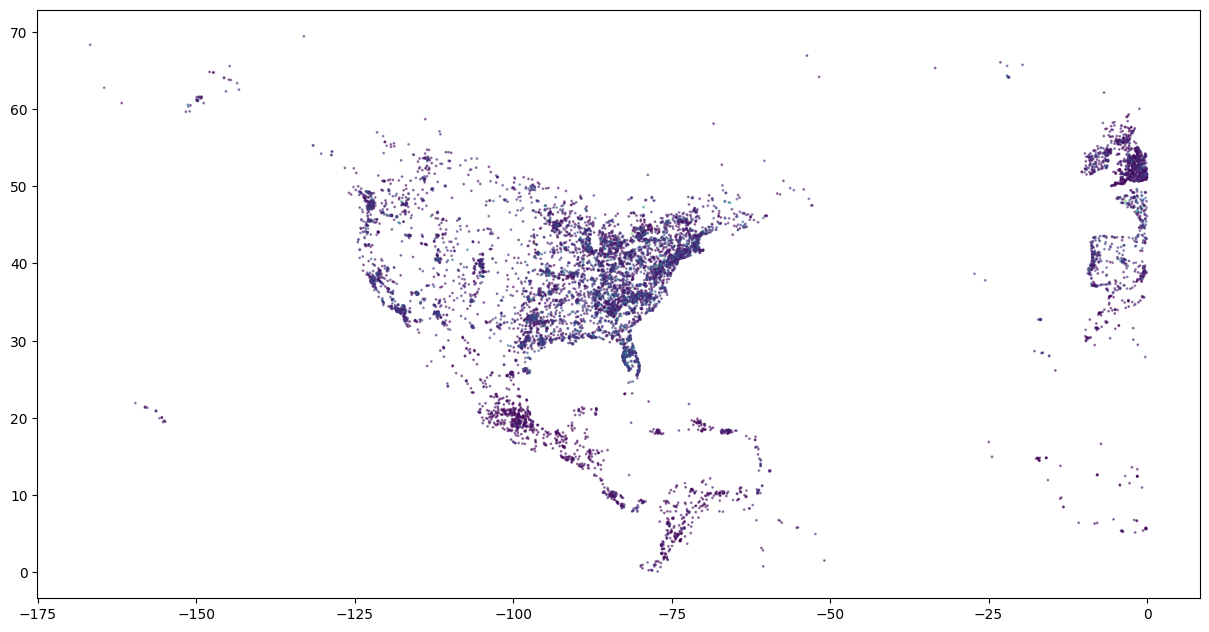

In [66]:

fig, ax = plt.subplots(figsize=(15, 10))
t[t.quadkey.str.startswith('0')].dropna().plot(ax=ax,  alpha=0.5, column="avg_d_kbps", 
                                               markersize=1)